## 4. Predicción de fugas de clientes en una compañía telefónica (7 puntos)

Una compañía telefónica está interesada en que desarrollemos un modelo que prediga los **100 clientes actuales** (dataset de explotaación) que tienen más probabilidad de abandonar la compañía. Para ello nos proporcionan una base de datos **fuga_clientes_empresa_telefonica_construccion.csv** con casos etiquetados, que usaremos para construir nuestro modelo de predicción.

Los campos de esta base de datos son:

* **Customer ID**

* **network_age**: antigüedad del cliente en días

* **Customer tenure in months:** antigüedad del cliente en meses

* **Total Spend in Months 1 and 2:** gasto total del cliente en los meses de referencia 1 y 2

* **Total SMS Spend:** gasto total en SMS

* **Total Data Spend:** gasto total en datos/internet

* **Total Data Consumption:** consumo total de datos (en KB) durante el período de estudio

* **Total Unique Calls:** número total de llamadas únicas

* **Total Onnet spend:** gasto total en llamadas a otros usuarios de la misma red de telefonía

* **Total Offnet spend:** gasto total en llamadas a otros usuarios de redes de telefonía diferentes

* **Total Call centre complaint calls:** número de llamadas de queja al call center

* **Network type subscription in Month 1:** suscripción de tipo de red en el mes 1. Esto indica la suscripción de red preferida de un cliente, lo que puede indicar su tipo de dispositivo: servicio 2G o 3G

* **Network type subscription in Month 2:** igual que el anterior pero en el mes posterior

* **Churn Status**: el valor es 1 si el cliente abandona la compañía telefónica, 0 si permanece en ella

* **Most Loved Competitor network in Month 1:** qué otro proveedor de la competencia prefiere el cliente en el mes 1. En realidad es un conjunto de columnas, cada una enfocada en un proveedor particular

* **Most Loved Competitor network in Month 2:** qué otro proveedor de la competencia prefiere el cliente en el mes 2. En realidad es un conjunto de columnas, cada una enfocada en un proveedor particular

La variable a predecir es **Churn Status**: el valor es 1 si el cliente **abandona** la compañía, 0 si no la abandona.

La compañía también nos proporciona otra base de datos, **fuga_clientes_empresa_telefonica_explotacion.csv**, con información sobre clientes de los que no se sabe ahora mismo si van a permanecer o no en la compañía. Por tanto en esta segunda base de datos todos los valores de la columna **Churn Status** son missing values (NaN).

La compañía nos pide que proporcionemos los IDs de los 100 clientes de la base de datos de explotación que con mayor probabilidad vayan a abandonar la compañía. Para ello proporcionaremos como entregable a la compañía un archivo csv con una sola columna, **Customer ID**, y 100 filas que contengan los IDs de los clientes seleccionados.

El fichero **ejemplo_fichero_predicciones.csv** contiene un ejemplo con el formato solicitado para este archivo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from datetime import datetime

In [2]:
datos_construccion = pd.read_csv("./fuga_clientes_empresa_telefonica_construccion.csv")
datos_explotacion  = pd.read_csv("./fuga_clientes_empresa_telefonica_explotacion.csv")

In [3]:
# Check if columns are exactly the same in both files:
sum(datos_construccion.columns != datos_explotacion.columns)

0

In [4]:
# Column to predict is "Churn Status"
# if it is 1, the client leaves the company
# if it is 1, the client stays

# These column values are known in "construcción" dataset:
datos_construccion["Churn Status"].values[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=int64)

In [5]:
# But are not known in "explotación" dataset:
datos_explotacion["Churn Status"].values[:10]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

### Previsualization of the data
By checking the data we can see the format of each column and also we can see that the first column (the ID) is not needed and relevant for building a model.

In [6]:
# Analyzing the data
print(datos_construccion.shape)
datos_construccion.head(5)

(1110, 25)


Customer ID  network_age  Customer tenure in month  \
0     ADF0039          123                      4.10   
1     ADF0041         1316                     43.87   
2     ADF0051         2385                     79.50   
3     ADF0059         1614                     53.80   
4     ADF0060         2175                     72.50   

   Total Spend in Months 1 and 2  Total SMS Spend  Total Data Spend  \
0                        76.7140             0.00              1.25   
1                        98.8904             4.14              1.25   
2                       372.6300             3.51              1.25   
3                       530.2000             6.85              1.25   
4                       554.1300             6.99            153.75   

   Total Data Consumption  Total Unique Calls  Total Onnet spend  \
0                  1.4951                  14                564   
1                  1.0244                  27               1626   
2                  6.0898                 119              10411   
3                  3.3447                  69               6822   
4             673204.0342                  33               3387   

   Total Offnet spend  ...  Most Loved Competitor network in Month 1_ToCall  \
0                6408  ...                                                0   
1                4373  ...                                                0   
2               22039  ...                                                0   
3                6274  ...                                                0   
4                7241  ...                                                0   

   Most Loved Competitor network in Month 1_Uxaa  \
0                                              1   
1                                              1   
2                                              0   
3                                              0   
4                                              0   

   Most Loved Competitor network in Month 1_Weematel  \
0                                                  0   
1                                                  0   
2                                                  1   
3                                                  0   
4                                                  1   

   Most Loved Competitor network in Month 1_Zintel  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Most Loved Competitor network in Month 2_Mango  \
0                                               1   
1                                               1   
2                                               1   
3                                               1   
4                                               1   

   Most Loved Competitor network in Month 2_PQza  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Most Loved Competitor network in Month 2_ToCall  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Most Loved Competitor network in Month 2_Uxaa  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Most Loved Competitor network in Month 2_Weematel  \
0                                                  0 

We remove the ID and the class to predict "Churn Status"

In [7]:
# Loading the data
nombres_atrs = list(datos_construccion.columns)
nombres_atrs.remove('Churn Status')
nombres_atrs.remove('Customer ID') # The customer ID is not needed.

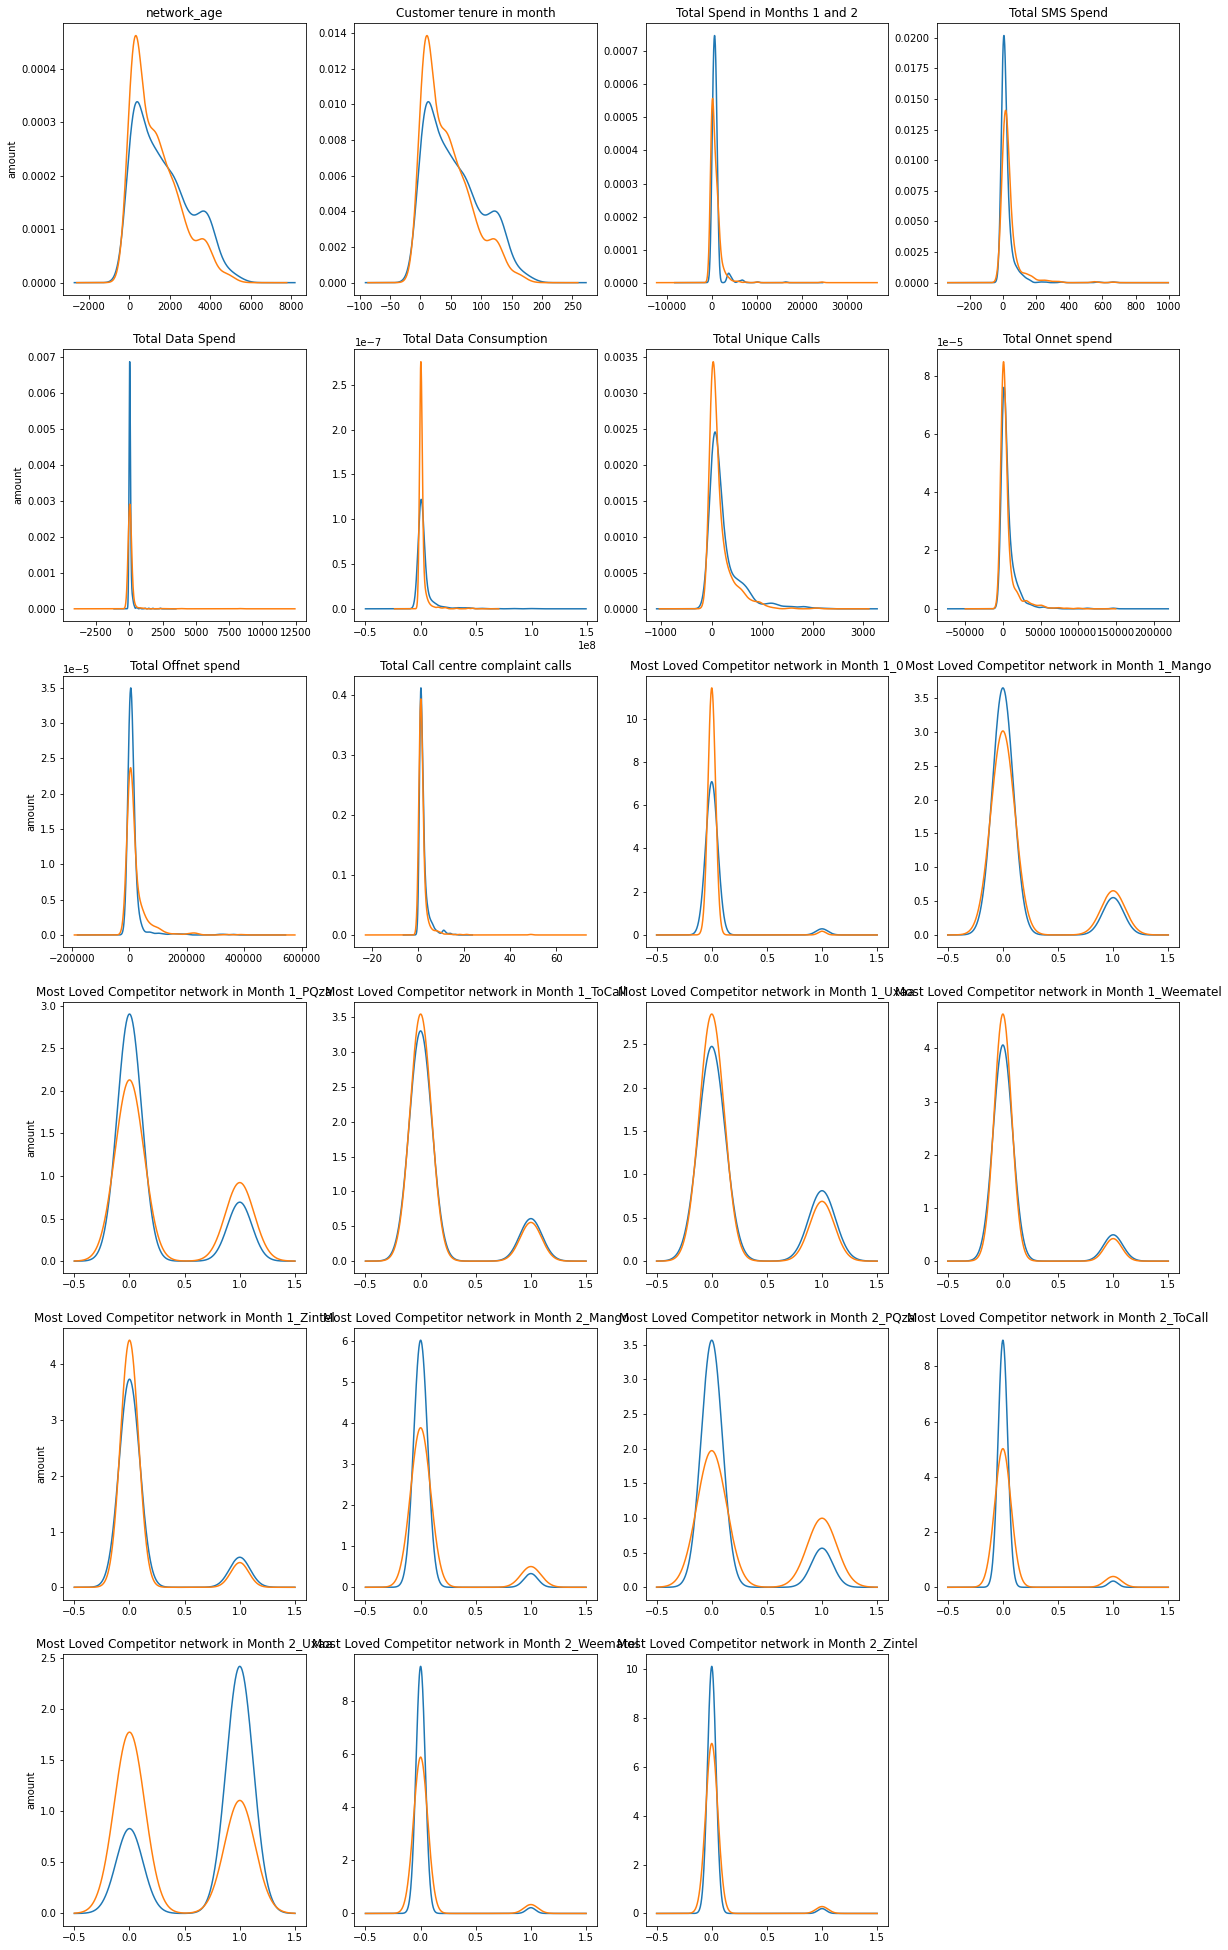

In [8]:
# Plotting the data
plt.figure(figsize=(20,35))
for i,n in enumerate(nombres_atrs):
    plt.subplot(6,4,i+1)
    aux = 'amount' if i%4==0 else ''
    datos_construccion.groupby("Churn Status")[n].plot(kind='kde', title=str(n))
    plt.ylabel(aux);

## Explanation of the histograms

We thought that some columns were not relevant for the training because the values of "yes" and "no" were too similar, and for testing the training we deleted them, but we realized that the scores given by the cross validations were worse than when including them, so at the end they were taken into account. One of the reasons why we think that this is happening is because, although the results of "yes" and "no" are very close, individually they should not contribute much, but for the correlation with the values of the other columns it should give information relevant to the training.

Although these values make better the training, the most important ones are the ones that vary a lot and have a lot of difference between the two returned values "yes" and "no".

In [ ]:
# If we want to not take into account columns we just have to remove the
# names from the varialbe nombres_atrs
"""
nombres_atrs.remove("Most Loved Competitor network in Month 1_ToCall")
"""

In [9]:
X = datos_construccion[nombres_atrs].values
y = datos_construccion["Churn Status"].values

##### Neural Network - Checking all the configurations having 3 layers. The number of the neurons in the layers go from 5 to 50 in steps of 5

In [ ]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time)

max_score = {'mean': 0.0, 'std': 0.0, 'layers': (0, 0, 0)}

for i in range(5, 50, 5):
    for n in range(5, 50, 5):
        for k in range(5, 50, 5):
            clf_nn = MLPClassifier(hidden_layer_sizes=(i,n,k), max_iter=1000, alpha=0)
            scores = cross_val_score(clf_nn, X, y, cv=3)
            if max_score['mean'] < scores.mean():
                max_score['mean'] = scores.mean()
                max_score['std'] = scores.std()
                max_score['layers'] = (i, n, k)
                
print("Maximum score of the model: {:.2f} +/- {:.2f}, layers configuration {0}".format(max_score['mean'], 
                                                                                       max_score['std'], 
                                                                                       max_score['layers']))

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Ending Time =", current_time)

Starting Time = 10:58:41


##### KNN - From 3 neighbors to 99 in steps of 2

In [ ]:
max_score = {'mean': 0.0, 'std': 0.0, 'neighbors': 0}

for i in range(3, 100, 2):
    clf_knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(clf_knn, X, y, cv=5)
    if max_score['mean'] < scores.mean():
                max_score['mean'] = scores.mean()
                max_score['std'] = scores.std()
                max_score['neighbors'] = i
                
print("Maximum score of the model: {:.2f} +/- {:.2f}, neighbors {:d}".format(max_score['mean'], max_score['std'], max_score['neighbors']))

##### Decision Tree - Depths from 2 to 99

In [ ]:
max_score = {'mean': 0.0, 'std': 0.0, 'depth': 0}

for i in range(2, 99):
    clf_dt = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(clf_dt, X, y, cv=5)
    if max_score['mean'] < scores.mean():
                max_score['mean'] = scores.mean()
                max_score['std'] = scores.std()
                max_score['depth'] = i

print("Score global del modelo: {:.2f} +/- {:.2f}, depth {:d}".format(max_score['mean'], max_score['std'], max_score['depth']))


### Results

All of the results above are the best ones reached, changing in all of them the number of equal parts that cross validation is going to divide the complete sample (cv).

* **Neural Network:** We have tried many ways, with a different amount of hidden layers and different number of neurons in each layer, also varying the iterations, but we didn't reacha good enough result. Better results between 0.55 and 0.62.

* **Knn:** We tried with different values of n, from n = 3 to n = 99, but it keeps in the same range of results between 0.60 and 0.64 the best ones. The best one is 0.64 using 39 neighbors.

* **Decision Tree:** With this model we obtained the best results in the cross validation score, reaching a maximum o 0.77 when a depth 5 is used, and for the cross validation, we divide the data set into 5 parts. This is the best result given, so this model is the one we are going to use to predict.


### Predictions on the new dataset

In [ ]:
# Fitting the model with all the data
clf_dt.fit(X, y)

Xnew = datos_explotacion[nombres_atrs].values
ynew = clf_dt.predict(Xnew)

In [ ]:
IDs = []
for i in range(len(datos_explotacion["Customer ID"])):
    if ynew[i] == 1:
        IDs.append(datos_explotacion["Customer ID"][i])     

In [ ]:
# Saving the first 100 results given in file "customers.csv"
customers = pd.DataFrame(IDs[:100], columns=['Customer ID'])
customers.to_csv('customers.csv', index=False)

## Final conclusion

After checking the performance of the neural network, the knn and the decision tree, we come to the conclusion that the __decision tree is the best model__ for this problem. At least in the labeled data.

Once we checked that we just simply trained the model without cross validation (using the entire data without testing). Then we just simply predict and store the prediction in a CSV.